importing modules

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [3]:
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix,classification_report,ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split,GridSearchCV
from imblearn.over_sampling import SVMSMOTE,SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_curve,precision_recall_curve
from sklearn.model_selection import cross_val_predict

In [4]:
from ydata_profiling import ProfileReport

reading in our data

In [126]:
filename="ai4i2020.csv"
data=pd.read_csv(filename,delimiter=',')
data.head()

UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  \
0                    1551         42.8                0                0    0   
1                    1408         46.3                3                0    0   
2                    1498         49.4                5                0    0   
3                    1433         39.5                7                0    0   
4                    1408         40.0                9                0    0   

   HDF  PWF  OSF  RNF  
0    0    0    0    0  
1    0    0    0    0  
2    0    0    0    0  
3    0    0    0    0  
4    0    0    0    0

renaming columns

In [6]:
cols={
    'Air temperature [K]':"AirTemp",
    'Process temperature [K]':"ProcessTemp",
    'Rotational speed [rpm]':'RotationSpeed',
    'Torque [Nm]':'Torque',
    'Tool wear [min]':'ToolWear',
    'Machine failure':"MachineFailure"
}
data.rename(cols,inplace=True,axis=1)
data.head()

UDI Product ID Type  AirTemp  ProcessTemp  RotationSpeed  Torque  ToolWear  \
0    1     M14860    M    298.1        308.6           1551    42.8         0   
1    2     L47181    L    298.2        308.7           1408    46.3         3   
2    3     L47182    L    298.1        308.5           1498    49.4         5   
3    4     L47183    L    298.2        308.6           1433    39.5         7   
4    5     L47184    L    298.2        308.7           1408    40.0         9   

   MachineFailure  TWF  HDF  PWF  OSF  RNF  
0               0    0    0    0    0    0  
1               0    0    0    0    0    0  
2               0    0    0    0    0    0  
3               0    0    0    0    0    0  
4               0    0    0    0    0    0

dropping irrelevant columns

In [7]:
data.drop(['UDI','Product ID'],inplace=True,axis=1)

EDA

In [8]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Type            10000 non-null  object 
 1   AirTemp         10000 non-null  float64
 2   ProcessTemp     10000 non-null  float64
 3   RotationSpeed   10000 non-null  int64  
 4   Torque          10000 non-null  float64
 5   ToolWear        10000 non-null  int64  
 6   MachineFailure  10000 non-null  int64  
 7   TWF             10000 non-null  int64  
 8   HDF             10000 non-null  int64  
 9   PWF             10000 non-null  int64  
 10  OSF             10000 non-null  int64  
 11  RNF             10000 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 937.6+ KB
None


confirming no null values

In [9]:
print(data.isna().sum())

Type              0
AirTemp           0
ProcessTemp       0
RotationSpeed     0
Torque            0
ToolWear          0
MachineFailure    0
TWF               0
HDF               0
PWF               0
OSF               0
RNF               0
dtype: int64


In [10]:
#confirmation of no null valueds
data=data.replace("?",np.NaN)
data.isna().sum()

Type              0
AirTemp           0
ProcessTemp       0
RotationSpeed     0
Torque            0
ToolWear          0
MachineFailure    0
TWF               0
HDF               0
PWF               0
OSF               0
RNF               0
dtype: int64

from above we have no null or empty values

checking for duplicated entries rowwise

In [11]:
duplicates=data.duplicated().sum()
print(f"{duplicates}  duplicated rows")

0  duplicated rows


convert numerical/int to float

In [12]:
for col in data.columns:
    try:
        data[col]=data[col].astype(float)
    except:
        pass
data.dtypes

Type               object
AirTemp           float64
ProcessTemp       float64
RotationSpeed     float64
Torque            float64
ToolWear          float64
MachineFailure    float64
TWF               float64
HDF               float64
PWF               float64
OSF               float64
RNF               float64
dtype: object

summary statistocs for numerical data

In [14]:
datanumeric=data.select_dtypes(include=np.number)
datanumeric.describe().T

count        mean         std     min     25%     50%  \
AirTemp         10000.0   300.00493    2.000259   295.3   298.3   300.1   
ProcessTemp     10000.0   310.00556    1.483734   305.7   308.8   310.1   
RotationSpeed   10000.0  1538.77610  179.284096  1168.0  1423.0  1503.0   
Torque          10000.0    39.98691    9.968934     3.8    33.2    40.1   
ToolWear        10000.0   107.95100   63.654147     0.0    53.0   108.0   
MachineFailure  10000.0     0.03390    0.180981     0.0     0.0     0.0   
TWF             10000.0     0.00460    0.067671     0.0     0.0     0.0   
HDF             10000.0     0.01150    0.106625     0.0     0.0     0.0   
PWF             10000.0     0.00950    0.097009     0.0     0.0     0.0   
OSF             10000.0     0.00980    0.098514     0.0     0.0     0.0   
RNF             10000.0     0.00190    0.043550     0.0     0.0     0.0   

                   75%     max  
AirTemp          301.5   304.5  
ProcessTemp      311.1   313.8  
RotationSpeed   1612.0  2886.0  
Torque            46.8    76.6  
ToolWear         162.0   253.0  
MachineFailure     0.0     1.0  
TWF                0.0     1.0  
HDF                0.0     1.0  
PWF                0.0     1.0  
OSF                0.0     1.0  
RNF                0.0     1.0

dropping failure types since we will be predicting simple machine failure

In [15]:
failures=['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
datanumeric.drop(failures,axis=1,inplace=True)
datanumeric

AirTemp  ProcessTemp  RotationSpeed  Torque  ToolWear  MachineFailure
0       298.1        308.6         1551.0    42.8       0.0             0.0
1       298.2        308.7         1408.0    46.3       3.0             0.0
2       298.1        308.5         1498.0    49.4       5.0             0.0
3       298.2        308.6         1433.0    39.5       7.0             0.0
4       298.2        308.7         1408.0    40.0       9.0             0.0
...       ...          ...            ...     ...       ...             ...
9995    298.8        308.4         1604.0    29.5      14.0             0.0
9996    298.9        308.4         1632.0    31.8      17.0             0.0
9997    299.0        308.6         1645.0    33.4      22.0             0.0
9998    299.0        308.7         1408.0    48.5      25.0             0.0
9999    299.0        308.7         1500.0    40.2      30.0             0.0

[10000 rows x 6 columns]

checking our target column

In [16]:
data['MachineFailure'].value_counts()

MachineFailure
0.0    9661
1.0     339
Name: count, dtype: int64

visualization of our target column value counts

<Axes: xlabel='MachineFailure', ylabel='count'>

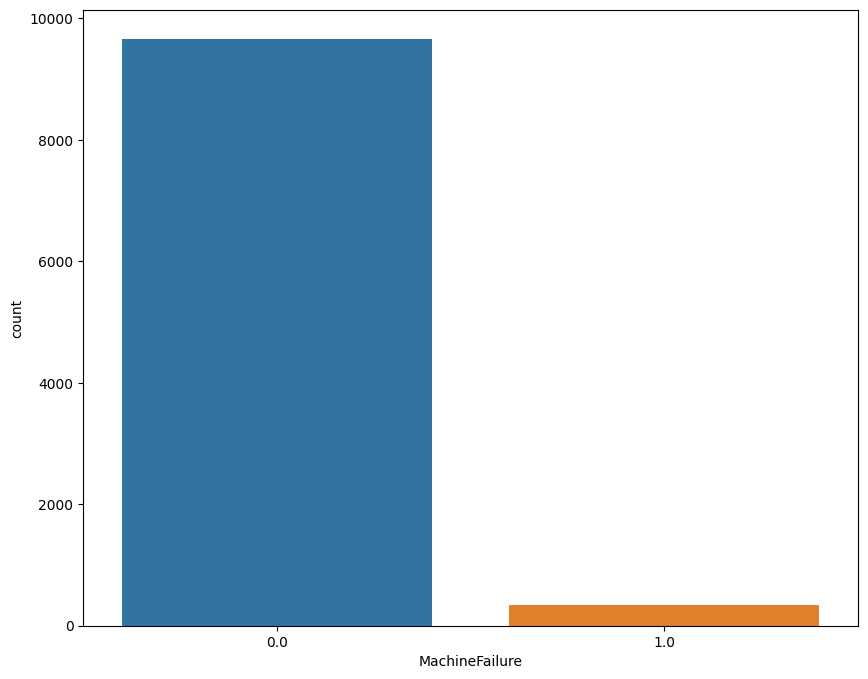

In [17]:
fig,ax=plt.subplots(figsize=(10,8))
sns.countplot(data,x="MachineFailure",ax=ax)

we have an inbalanced targget column
apply SMOTE later on

machine failures by type(L,M,H)

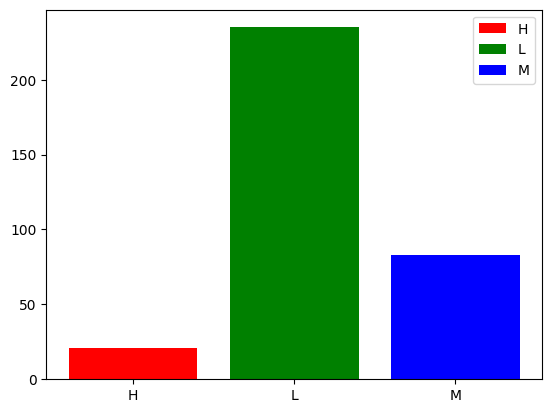

In [18]:
types=data.groupby("Type")["MachineFailure"].sum()
plt.bar(types.index,types.values,color=['r','g','b'],label=types.index)
plt.legend()
plt.show()

types=data.groupby("Type")["MachineFailure"].sum()
px.bar(types,)

histogram to know distribution of different columns

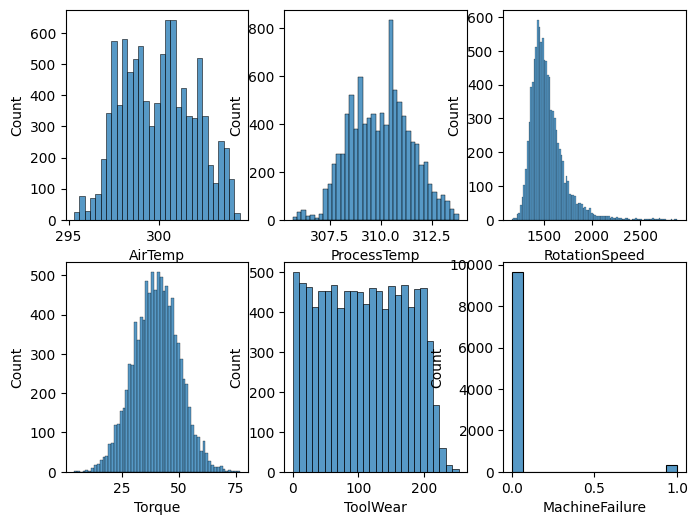

In [19]:
fig,ax=plt.subplots(2,3,figsize=(8,6))
for i,col in enumerate(datanumeric.columns):
    sns.histplot(datanumeric[col],ax=ax[i//3][i%3])

    

rotation speed negatively skewed
almost normal distribuution for other columns except tool wear

Boxplot to show outliers

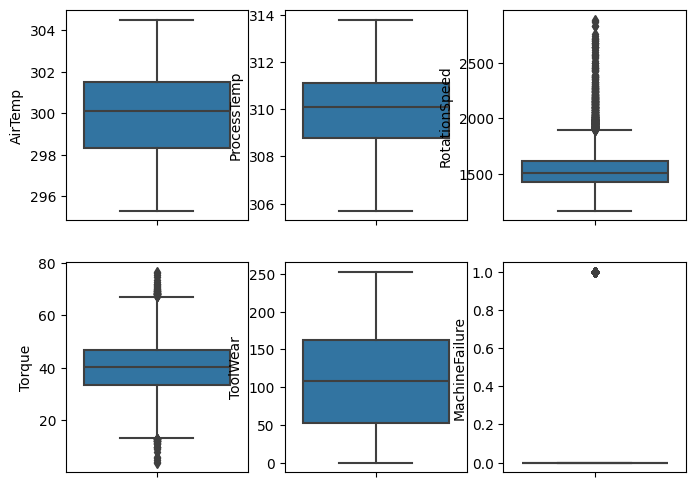

In [20]:
fig,axes=plt.subplots(2,3,figsize=(8,6))
for i,col in enumerate(datanumeric.columns):
    sns.boxplot(datanumeric,y=col,ax=axes[i//3][i%3])

boxplot with respect to machine failure

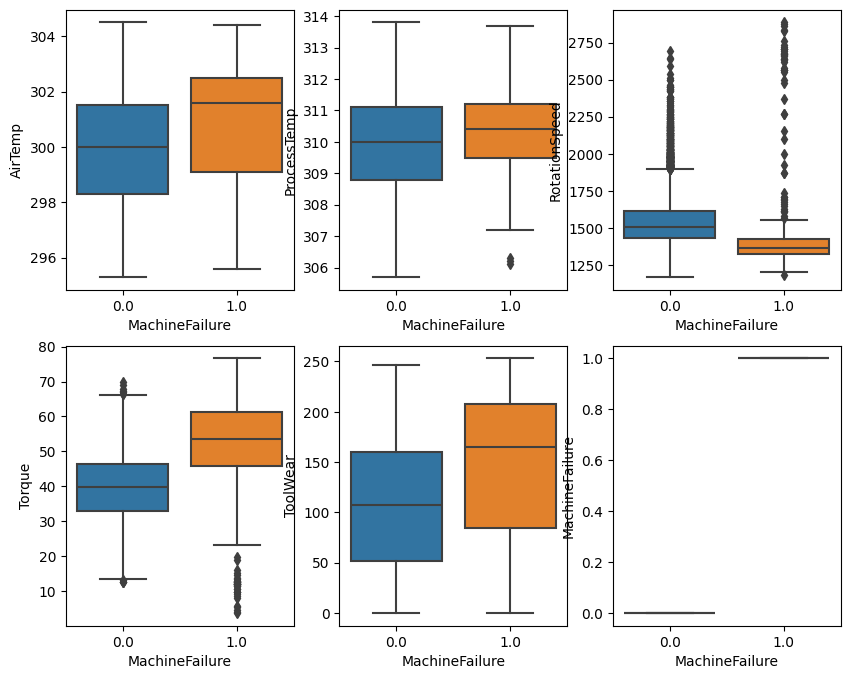

In [21]:
fig,axes=plt.subplots(2,3,figsize=(10,8))
for i,col in enumerate(datanumeric.columns):
    sns.boxplot(data,x='MachineFailure',y=col,ax=axes[i//3][i%3])

pairplots among features

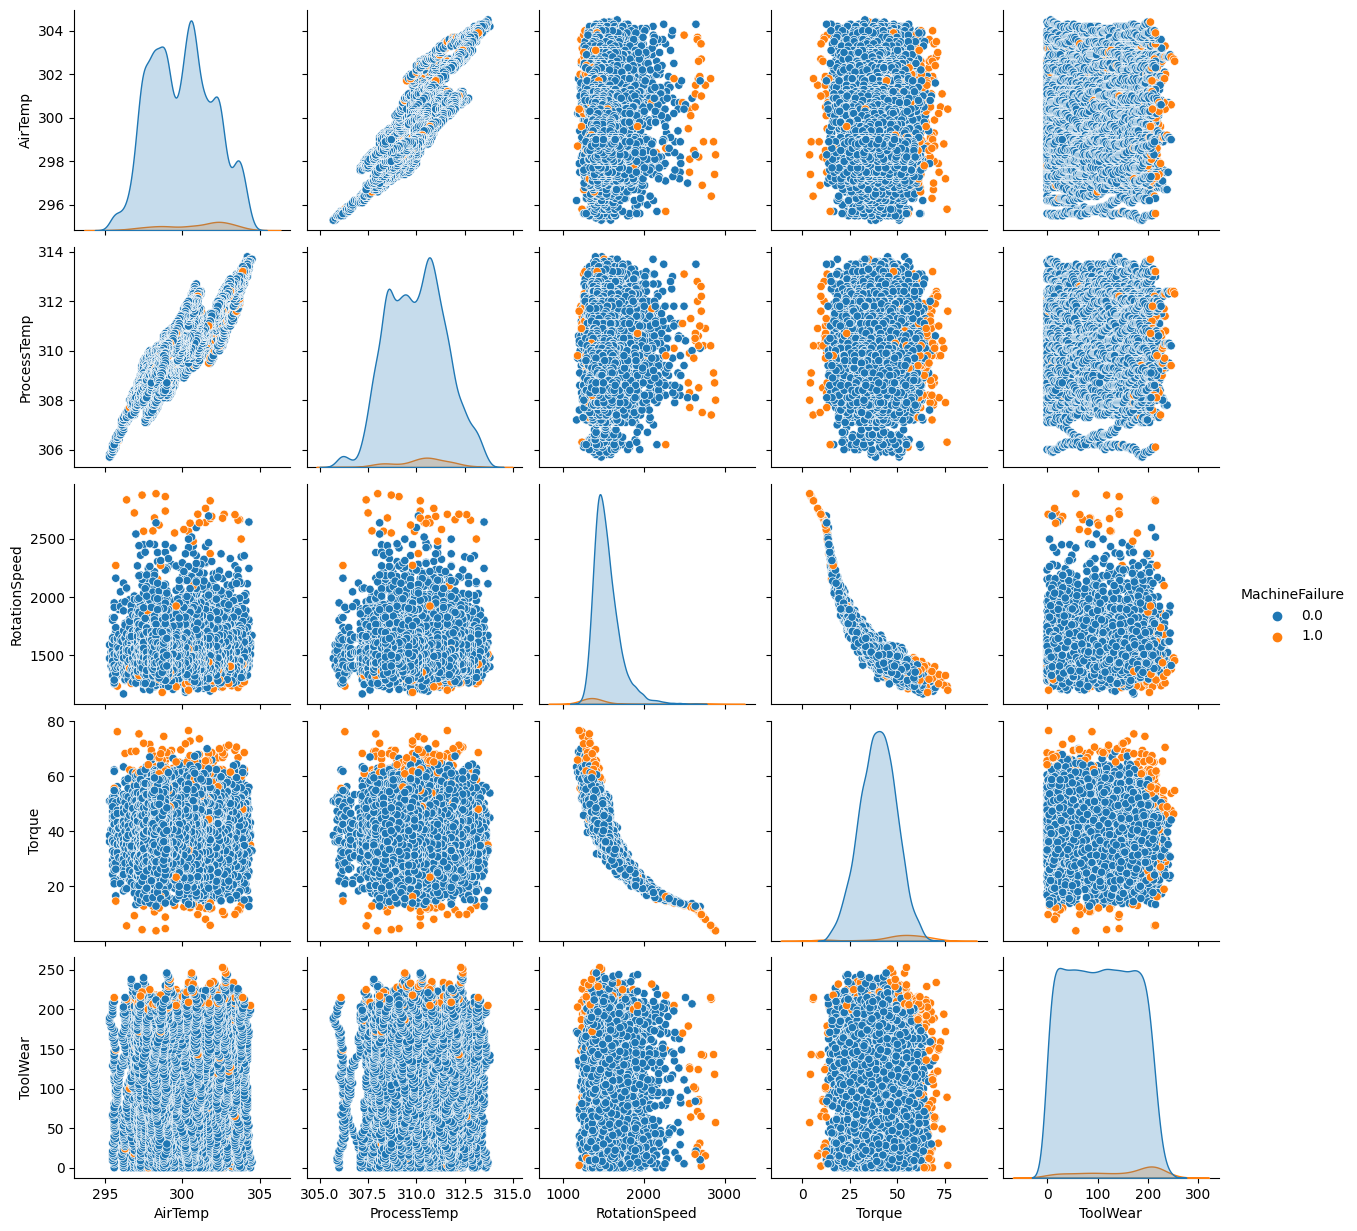

In [22]:
sns.pairplot(datanumeric, hue='MachineFailure',)

handling outliers

we will not remove outliers since they are the possible indicators of machine failures

below are possible ways we could have dealt with them groupwise

In [171]:
data_no_outliers=data.copy()
data_no_outliers.drop(['TWF','HDF','PWF','OSF','RNF'],inplace=True,axis=1)
types=data_no_outliers.groupby('Type')
for type,group in types:
    group.drop(['Type','MachineFailure'],inplace=True,axis=1)
    for col in group.columns:
        q1=group[col].quantile(0.25)
        q3=group[col].quantile(0.75)
        iqr=q3-q1
        upper_quantile=q3+(1.5*iqr)
        lower_quantile=q1-(1.5*iqr)
        outliers=data_no_outliers.loc[((data_no_outliers[col]>=upper_quantile) | (data_no_outliers[col]<=lower_quantile))]
        data_no_outliers.drop(outliers.index,inplace=True)
        

In [172]:
failures=data_no_outliers.groupby('MachineFailure')
for failure,group in failures:
    group.drop(['Type','MachineFailure'],inplace=True,axis=1)
    for col in group.columns:
        q1=group[col].quantile(0.25)
        q3=group[col].quantile(0.75)
        iqr=q3-q1
        upper_quantile=q3+(1.5*iqr)
        lower_quantile=q1-(1.5*iqr)
        outliers=data_no_outliers.loc[((data_no_outliers[col]>=upper_quantile) | (data_no_outliers[col]<=lower_quantile))]
        data_no_outliers.drop(outliers.index,inplace=True)

In [18]:
data_type=data.copy()
data_type.drop(['TWF','HDF','PWF','OSF','RNF'],inplace=True,axis=1)
types=data_type.groupby('Type')
for type,group in types:
    group.drop(['Type','MachineFailure'],inplace=True,axis=1)
    for col in group.columns:
        q1=group[col].quantile(0.25)
        q3=group[col].quantile(0.75)
        iqr=q3-q1
        upper_quantile=q3+(1.5*iqr)
        lower_quantile=q1-(1.5*iqr)
        outliers=data_type.loc[((data_type[col]>=upper_quantile) | (data_type[col]<=lower_quantile))]
        data_type.drop(outliers.index,inplace=True)


In [173]:
data_failure=data.copy()
data_failure.drop(['TWF','HDF','PWF','OSF','RNF'],inplace=True,axis=1)
types=data_failure.groupby('MachineFailure')
for type,group in types:
    group.drop(['Type','MachineFailure'],inplace=True,axis=1)
    for col in group.columns:
        q1=group[col].quantile(0.25)
        q3=group[col].quantile(0.75)
        iqr=q3-q1
        upper_quantile=q3+(1.5*iqr)
        lower_quantile=q1-(1.5*iqr)
        outliers=data_failure.loc[((data_failure[col]>=upper_quantile) | (data_failure[col]<=lower_quantile))]
        data_failure.drop(outliers.index,inplace=True)
data_failure

Type  AirTemp  ProcessTemp  RotationSpeed  Torque  ToolWear  \
0       M    298.1        308.6         1551.0    42.8       0.0   
1       L    298.2        308.7         1408.0    46.3       3.0   
2       L    298.1        308.5         1498.0    49.4       5.0   
3       L    298.2        308.6         1433.0    39.5       7.0   
4       L    298.2        308.7         1408.0    40.0       9.0   
...   ...      ...          ...            ...     ...       ...   
9990    L    298.8        308.5         1527.0    36.2       3.0   
9992    L    298.8        308.4         1484.0    39.2       8.0   
9993    L    298.8        308.4         1401.0    47.3      10.0   
9998    H    299.0        308.7         1408.0    48.5      25.0   
9999    M    299.0        308.7         1500.0    40.2      30.0   

      MachineFailure  
0                0.0  
1                0.0  
2                0.0  
3                0.0  
4                0.0  
...              ...  
9990             0.0  
9992             0.0  
9993             0.0  
9998             0.0  
9999             0.0  

[6418 rows x 7 columns]

correlation among numeric variables

<Axes: >

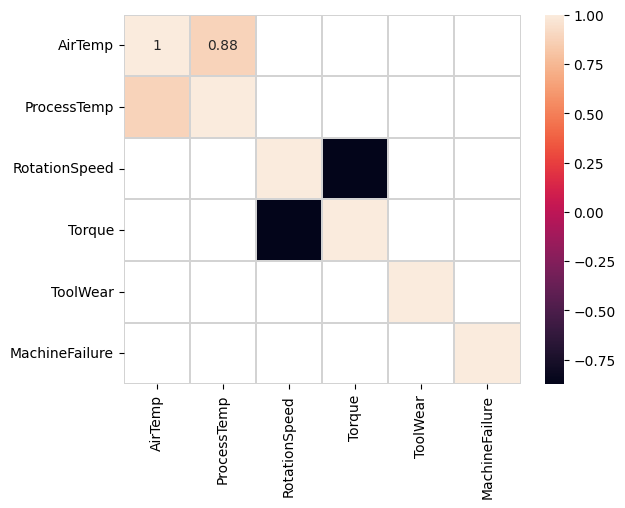

In [23]:
cor=datanumeric.corr()
threshold=0.8
mask=np.where((np.abs(cor)>threshold),False,True)
sns.heatmap(cor,annot=True,mask=mask,linewidth=0.3,linecolor='lightgrey',)

checking inconsistencies between machine failure and different types of failures

In [24]:
poor=data.loc[(data['MachineFailure']==1) & 
((data['TWF']==0)&(data['HDF']==0 )&(data['PWF']==0 )&(data['OSF']==0 )&(data['RNF']==0 ))]

In [25]:
poor=data.loc[(data['MachineFailure']==1) & 
((data['TWF']==0)&(data['HDF']==0 )&(data['PWF']==0 )&(data['OSF']==0 )&(data['RNF']==0 ))]
data.drop(poor.index,inplace=True)

In [26]:
poor=data.loc[(data['MachineFailure']==0) & 
((data['TWF']==1)|(data['HDF']==1 )|(data['PWF']==1 )|(data['OSF']==1 )|(data['RNF']==1)),"MachineFailure"]=1

data.loc[(data['MachineFailure']==0) & 
((data['TWF']==1)|(data['HDF']==1 )|(data['PWF']==1 )|(data['OSF']==1 )|(data['RNF']==1))]

In [27]:
data['MachineFailure'].value_counts()

MachineFailure
0.0    9643
1.0     348
Name: count, dtype: int64

PROFILE REPORT

In [28]:
data1=data.copy()

In [29]:
failures=['TWF','HDF','PWF','OSF','RNF']
data1.drop(failures,axis=1,inplace=True)

In [30]:
report=ProfileReport(
    data1,
    title="Profile Report",
    dataset={
        "author":"Mark Ndung'u Njuguna",
    }
)

In [31]:
report.to_file('ProfileReport')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

drop failure types

In [32]:
failures=['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
data.drop(failures,axis=1,inplace=True)
data

Type  AirTemp  ProcessTemp  RotationSpeed  Torque  ToolWear  \
0       M    298.1        308.6         1551.0    42.8       0.0   
1       L    298.2        308.7         1408.0    46.3       3.0   
2       L    298.1        308.5         1498.0    49.4       5.0   
3       L    298.2        308.6         1433.0    39.5       7.0   
4       L    298.2        308.7         1408.0    40.0       9.0   
...   ...      ...          ...            ...     ...       ...   
9995    M    298.8        308.4         1604.0    29.5      14.0   
9996    H    298.9        308.4         1632.0    31.8      17.0   
9997    M    299.0        308.6         1645.0    33.4      22.0   
9998    H    299.0        308.7         1408.0    48.5      25.0   
9999    M    299.0        308.7         1500.0    40.2      30.0   

      MachineFailure  
0                0.0  
1                0.0  
2                0.0  
3                0.0  
4                0.0  
...              ...  
9995             0.0  
9996             0.0  
9997             0.0  
9998             0.0  
9999             0.0  

[9991 rows x 7 columns]

Machine Learning

splitting our data into train and test data

In [33]:
x=data.drop('MachineFailure',axis=1)
y=data['MachineFailure']

In [34]:
xtrain,xtest,ytrain,ytest=train_test_split(x,y,random_state=40,stratify=y,test_size=0.2)

In [35]:
cat=list(x.select_dtypes(np.object_))
num=list(x.select_dtypes(np.number))

oversampler=SVMSMOTE(random_state=40)
xtrain,ytrain=oversampler.fit_resample(xtrain,ytrain)

creating a pipeline to partly transform our x data

In [36]:
full_pipe=ColumnTransformer(
    [
        ("numerical",StandardScaler(),list(xtrain.select_dtypes(np.number))),
        ("categorical",OneHotEncoder(),list(xtrain.select_dtypes(np.object_)))
    ]
)
full_pipe.fit(xtrain)


ColumnTransformer(transformers=[('numerical', StandardScaler(),
                                 ['AirTemp', 'ProcessTemp', 'RotationSpeed',
                                  'Torque', 'ToolWear']),
                                ('categorical', OneHotEncoder(), ['Type'])])

In [37]:
x_prep=full_pipe.fit_transform(xtrain)
x_prep

array([[ 2.10583223,  2.22958144, -0.42369542, ...,  0.        ,
         1.        ,  0.        ],
       [-0.60224724, -0.81800215, -0.55287288, ...,  0.        ,
         0.        ,  1.        ],
       [-1.05359381, -1.08889846,  0.54794376, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [ 0.45089478,  1.34916841, -0.77191293, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.14999706,  0.73965169, -1.06396632, ...,  0.        ,
         0.        ,  1.        ],
       [-0.95329457, -0.61482991,  0.18287702, ...,  0.        ,
         0.        ,  1.        ]])

In [38]:
x_prep.shape

(7992, 8)

In [39]:
columns=full_pipe.get_feature_names_out()
x_prep1=pd.DataFrame(x_prep,columns=columns)
x_prep1

numerical__AirTemp  numerical__ProcessTemp  numerical__RotationSpeed  \
0               2.105832                2.229581                 -0.423695   
1              -0.602247               -0.818002                 -0.552873   
2              -1.053594               -1.088898                  0.547944   
3               1.102840                1.078272                 -0.030547   
4               0.099847                0.942824                  0.171644   
...                  ...                     ...                       ...   
7987           -0.251200                0.536479                  1.205064   
7988           -0.501948               -0.818002                 -0.884241   
7989            0.450895                1.349168                 -0.771913   
7990            0.149997                0.739652                 -1.063966   
7991           -0.953295               -0.614830                  0.182877   

      numerical__Torque  numerical__ToolWear  categorical__Type_H  \
0              0.602250            -0.944083                  0.0   
1              0.060436            -0.709151                  0.0   
2             -0.541579             1.295598                  1.0   
3             -0.270672            -1.053718                  1.0   
4             -0.461310             0.465507                  0.0   
...                 ...                  ...                  ...   
7987          -0.862653             0.089616                  0.0   
7988           1.866481             1.420895                  1.0   
7989           1.083862             1.201626                  0.0   
7990           1.886548             0.340210                  0.0   
7991          -0.240571             0.277561                  0.0   

      categorical__Type_L  categorical__Type_M  
0                     1.0                  0.0  
1                     0.0                  1.0  
2                     0.0                  0.0  
3                     0.0                  0.0  
4                     0.0                  1.0  
...                   ...                  ...  
7987                  0.0                  1.0  
7988                  0.0                  0.0  
7989                  0.0                  1.0  
7990                  0.0                  1.0  
7991                  0.0                  1.0  

[7992 rows x 8 columns]

In [40]:
ytrain.value_counts()

MachineFailure
0.0    7714
1.0     278
Name: count, dtype: int64

oversampling oour data to have balanced data set

In [41]:
from imblearn.over_sampling import SVMSMOTE
sm=SVMSMOTE(sampling_strategy="minority")
xtrain_sampled,ytrain_sampled=sm.fit_resample(x_prep1,ytrain)

In [42]:
ytrain_sampled.value_counts()

MachineFailure
0.0    7714
1.0    7714
Name: count, dtype: int64

Searching for the best model

function to store different model evaluation metrics

In [43]:
model_stats=pd.DataFrame(columns=['accuracy','precision','recall','f1_score'])
def performer(model,ytest,ypred):
    accuracy=accuracy_score(ytest,ypred)
    precision = precision_score(ytest, ypred, average='weighted')
    recall = recall_score(ytest, ypred, average='weighted')
    f1 = f1_score(ytest, ypred, average='weighted')
    model_stats.loc[model]=[accuracy,precision,recall,f1]

DECISION TREE

In [44]:
model=DecisionTreeClassifier()
params={"max_depth":[7,8,9,10,11,12,13,14,15]}
modelcv=GridSearchCV(model,params,cv=10)
modelcv.fit(x_prep1,ytrain)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [7, 8, 9, 10, 11, 12, 13, 14, 15]})

In [45]:
modelcv.best_params_

{'max_depth': 11}

In [46]:
results=pd.DataFrame(modelcv.cv_results_)
results

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.047443      0.016295         0.007663        0.001189   
1       0.040066      0.000778         0.006729        0.000466   
2       0.047392      0.004166         0.007304        0.000857   
3       0.049928      0.003084         0.007663        0.001839   
4       0.051399      0.000633         0.006986        0.000204   
5       0.053426      0.000851         0.006777        0.000181   
6       0.055983      0.001870         0.006750        0.000289   
7       0.056172      0.001687         0.006619        0.000225   
8       0.056652      0.001953         0.006581        0.000195   

  param_max_depth             params  split0_test_score  split1_test_score  \
0               7   {'max_depth': 7}            0.97375            0.97875   
1               8   {'max_depth': 8}            0.98125            0.98000   
2               9   {'max_depth': 9}            0.98375            0.98250   
3              10  {'max_depth': 10}            0.98375            0.98625   
4              11  {'max_depth': 11}            0.98375            0.98250   
5              12  {'max_depth': 12}            0.98500            0.97750   
6              13  {'max_depth': 13}            0.98250            0.98125   
7              14  {'max_depth': 14}            0.98125            0.97875   
8              15  {'max_depth': 15}            0.97625            0.98000   

   split2_test_score  split3_test_score  split4_test_score  split5_test_score  \
0           0.984981           0.978723           0.979975           0.982478   
1           0.983730           0.981227           0.982478           0.982478   
2           0.983730           0.978723           0.982478           0.983730   
3           0.984981           0.978723           0.979975           0.981227   
4           0.983730           0.982478           0.981227           0.982478   
5           0.982478           0.982478           0.978723           0.982478   
6           0.981227           0.978723           0.981227           0.978723   
7           0.983730           0.977472           0.977472           0.977472   
8           0.981227           0.977472           0.979975           0.978723   

   split6_test_score  split7_test_score  split8_test_score  split9_test_score  \
0           0.976220           0.968711           0.977472           0.979975   
1           0.979975           0.976220           0.979975           0.978723   
2           0.982478           0.974969           0.977472           0.982478   
3           0.978723           0.973717           0.977472           0.981227   
4           0.982478           0.976220           0.981227           0.979975   
5           0.981227           0.974969           0.979975           0.979975   
6           0.976220           0.971214           0.977472           0.976220   
7           0.977472           0.971214           0.976220           0.974969   
8           0.974969           0.969962           0.979975           0.976220   

   mean_test_score  std_test_score  rank_test_score  
0         0.978104        0.004305                7  
1         0.980606        0.002037                3  
2         0.981231        0.002911                2  
3         0.980605        0.003556                4  
4         0.981606        0.002101                1  
5         0.980480        0.002753                5  
6         0.978478        0.003210                6  
7         0.977602        0.003192                8  
8         0.977477        0.003167                9

In [47]:
model=modelcv.best_estimator_

In [48]:
model.fit(xtrain_sampled,ytrain_sampled)

DecisionTreeClassifier(max_depth=11)

In [49]:
ypredicted=cross_val_predict(model,xtrain_sampled,ytrain_sampled,cv=10)

In [50]:
performer(model,ytrain_sampled,ypredicted)

In [51]:
model_stats

accuracy  precision    recall  f1_score
DecisionTreeClassifier(max_depth=11)  0.978999   0.979056  0.978999  0.978999

KNN MODEL

In [52]:
model=KNeighborsClassifier()
params={"n_neighbors":range(2,10)}
modelcv=GridSearchCV(model,params,cv=5)
modelcv.fit(xtrain_sampled,ytrain_sampled)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(2, 10)})

In [53]:
modelcv.best_params_

{'n_neighbors': 2}

In [54]:
results=pd.DataFrame(modelcv.cv_results_)
results

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.037332      0.001471         0.702307        0.036603   
1       0.036074      0.000679         0.695305        0.005959   
2       0.036170      0.000993         0.708653        0.007105   
3       0.035673      0.000318         0.707774        0.002817   
4       0.035631      0.000263         0.716389        0.001835   
5       0.035880      0.000617         0.725726        0.005359   
6       0.036432      0.000485         0.749990        0.028531   
7       0.037037      0.000847         0.772014        0.034559   

  param_n_neighbors              params  split0_test_score  split1_test_score  \
0                 2  {'n_neighbors': 2}           0.977641           0.986714   
1                 3  {'n_neighbors': 3}           0.973104           0.980557   
2                 4  {'n_neighbors': 4}           0.972780           0.982502   
3                 5  {'n_neighbors': 5}           0.967596           0.976669   
4                 6  {'n_neighbors': 6}           0.967596           0.976993   
5                 7  {'n_neighbors': 7}           0.962735           0.973104   
6                 8  {'n_neighbors': 8}           0.963383           0.973428   
7                 9  {'n_neighbors': 9}           0.958846           0.970188   

   split2_test_score  split3_test_score  split4_test_score  mean_test_score  \
0           0.987038           0.986710           0.990600         0.985741   
1           0.980881           0.979903           0.983144         0.979518   
2           0.982178           0.981524           0.984117         0.980620   
3           0.976021           0.975365           0.979579         0.975046   
4           0.977965           0.976661           0.981199         0.976083   
5           0.971808           0.973420           0.977958         0.971805   
6           0.973104           0.973744           0.979903         0.972712   
7           0.970188           0.970827           0.977310         0.969472   

   std_test_score  rank_test_score  
0        0.004308                1  
1        0.003387                3  
2        0.004012                2  
3        0.003993                5  
4        0.004537                4  
5        0.004988                7  
6        0.005300                6  
7        0.005953                8

In [55]:
model=modelcv.best_estimator_

In [56]:
model.fit(xtrain_sampled,ytrain_sampled)

KNeighborsClassifier(n_neighbors=2)

In [57]:
ypredicted=cross_val_predict(model,xtrain_sampled,ytrain_sampled,cv=10)

In [58]:
performer(model,ytrain_sampled,ypredicted)

In [59]:
model_stats

accuracy  precision    recall  f1_score
DecisionTreeClassifier(max_depth=11)  0.978999   0.979056  0.978999  0.978999
KNeighborsClassifier(n_neighbors=2)   0.986388   0.986477  0.986388  0.986388

RANDOM FOREST

In [60]:
model=RandomForestClassifier()
params={
    "n_estimators":range(80,100),
    'max_depth':range(6,12),
}
gridmodel=GridSearchCV(
    model,
    param_grid=params,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1,
    cv=5
)

In [61]:
gridmodel.fit(xtrain_sampled,ytrain_sampled)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': range(6, 12),
                         'n_estimators': range(80, 100)},
             scoring='accuracy', verbose=1)

In [62]:
gridmodel.best_score_

0.982370195928494

In [63]:
gridmodel.best_params_

{'max_depth': 11, 'n_estimators': 90}

In [64]:
results=pd.DataFrame(gridmodel.cv_results_)
results

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0         1.842169      0.092363         0.040991        0.000938   
1         2.013779      0.166925         0.048353        0.009641   
2         1.829218      0.036768         0.041343        0.001640   
3         1.853976      0.037957         0.044010        0.003448   
4         1.868643      0.042234         0.041952        0.000920   
..             ...           ...              ...             ...   
115       2.881241      0.087858         0.064181        0.007452   
116       2.918937      0.044998         0.062501        0.003406   
117       2.925402      0.077285         0.071253        0.016833   
118       2.979702      0.058715         0.060737        0.001314   
119       2.996615      0.048389         0.062943        0.001398   

    param_max_depth param_n_estimators                                 params  \
0                 6                 80   {'max_depth': 6, 'n_estimators': 80}   
1                 6                 81   {'max_depth': 6, 'n_estimators': 81}   
2                 6                 82   {'max_depth': 6, 'n_estimators': 82}   
3                 6                 83   {'max_depth': 6, 'n_estimators': 83}   
4                 6                 84   {'max_depth': 6, 'n_estimators': 84}   
..              ...                ...                                    ...   
115              11                 95  {'max_depth': 11, 'n_estimators': 95}   
116              11                 96  {'max_depth': 11, 'n_estimators': 96}   
117              11                 97  {'max_depth': 11, 'n_estimators': 97}   
118              11                 98  {'max_depth': 11, 'n_estimators': 98}   
119              11                 99  {'max_depth': 11, 'n_estimators': 99}   

     split0_test_score  split1_test_score  split2_test_score  \
0             0.956254           0.953662           0.965327   
1             0.949125           0.961115           0.959170   
2             0.951069           0.958846           0.964355   
3             0.952366           0.956578           0.961115   
4             0.950421           0.962087           0.965975   
..                 ...                ...                ...   
115           0.970836           0.984122           0.981854   
116           0.972132           0.984770           0.981205   
117           0.973428           0.985742           0.980557   
118           0.973104           0.984122           0.981854   
119           0.971160           0.985742           0.980881   

     split3_test_score  split4_test_score  mean_test_score  std_test_score  \
0             0.964992           0.971799         0.962407        0.006599   
1             0.960778           0.973420         0.960722        0.007724   
2             0.968882           0.975365         0.963703        0.008324   
3             0.964019           0.976013         0.962018        0.008043   
4             0.964344           0.975365         0.963638        0.008007   
..                 ...                ...              ...             ...   
115           0.983468           0.987682         0.981592        0.005706   
116           0.982496           0.989951         0.982111        0.005815   
117           0.984765           0.987034         0.982305        0.004941   
118           0.982820           0.988979         0.982176        0.005155   
119           0.981848           0.986062         0.981139        0.005396   

     rank_test_score  
0                112  
1                119  
2                107  
3                114  
4                108  
..               ...  
115               14  
116                4  
117                2  
118                3  
119               20  

[120 rows x 15 columns]

In [65]:
model=gridmodel.best_estimator_
model.fit(xtrain_sampled,ytrain_sampled)

RandomForestClassifier(max_depth=11, n_estimators=90)

In [66]:
ypredicted=cross_val_predict(model,xtrain_sampled,ytrain_sampled,cv=10)

In [67]:
performer(model[0],ytrain_sampled,ypredicted)

In [68]:
model_stats

accuracy  precision  \
DecisionTreeClassifier(max_depth=11)                0.978999   0.979056   
KNeighborsClassifier(n_neighbors=2)                 0.986388   0.986477   
DecisionTreeClassifier(max_depth=11, max_featur...  0.982175   0.982255   

                                                      recall  f1_score  
DecisionTreeClassifier(max_depth=11)                0.978999  0.978999  
KNeighborsClassifier(n_neighbors=2)                 0.986388  0.986388  
DecisionTreeClassifier(max_depth=11, max_featur...  0.982175  0.982175

FEATURE IMPORTANCE

In [69]:
model.feature_importances_

array([0.09780469, 0.0578531 , 0.34113751, 0.32848943, 0.12883773,
       0.00792313, 0.02547207, 0.01248234])

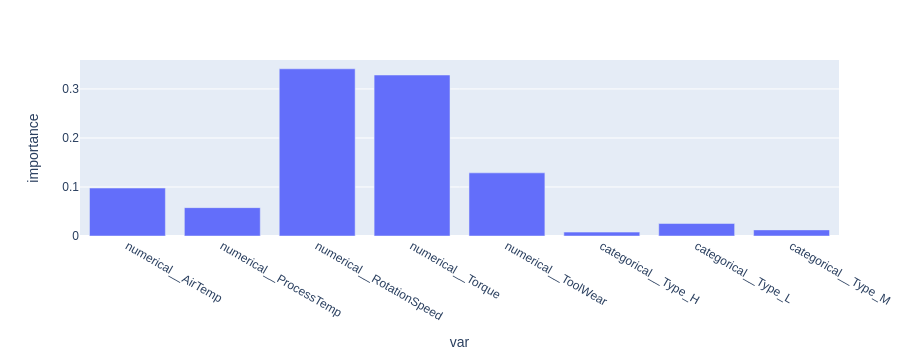

In [70]:
importance=pd.DataFrame({
    'var':xtrain_sampled.columns,
    'importance':model.feature_importances_
}
)
importance.sort_values(by="importance",ascending=False)
px.bar(importance,x="var",y="importance")

Our best model according to accuracy is is a KNN  classifier,2 neighbors but upon examining recall and precision,Decision Tree classifier came on top with  a depth of 15

Full model with preprocessin and prediction capabilities

In [81]:
model_pipe=Pipeline(
    [
        ("preprocessing",full_pipe),
        ("model",DecisionTreeClassifier(max_depth=15))
    ]
)


In [82]:
xtrain_sampled.columns

Index(['numerical__AirTemp', 'numerical__ProcessTemp',
       'numerical__RotationSpeed', 'numerical__Torque', 'numerical__ToolWear',
       'categorical__Type_H', 'categorical__Type_L', 'categorical__Type_M'],
      dtype='object')

In [83]:
model_pipe[1]

DecisionTreeClassifier(max_depth=15)

fitting in our data

In [84]:
model_pipe.fit(xtrain,ytrain)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numerical', StandardScaler(),
                                                  ['AirTemp', 'ProcessTemp',
                                                   'RotationSpeed', 'Torque',
                                                   'ToolWear']),
                                                 ('categorical',
                                                  OneHotEncoder(),
                                                  ['Type'])])),
                ('model', DecisionTreeClassifier(max_depth=15))])

model with original data

In [85]:
model=DecisionTreeClassifier(max_depth=15)
model.fit(x_prep,ytrain)

DecisionTreeClassifier(max_depth=15)

In [86]:
x_prep.shape

(7992, 8)

In [87]:
model.score(x_prep,ytrain)

0.9987487487487487

In [88]:
9643/(9643+348)

0.9651686517866079

In [89]:
ypredicted=cross_val_predict(model,x_prep,ytrain,cv=3)

In [90]:
print(classification_report(ytrain,ypredicted))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      7714
         1.0       0.66      0.61      0.63       278

    accuracy                           0.98      7992
   macro avg       0.82      0.80      0.81      7992
weighted avg       0.97      0.98      0.97      7992



confusion matrix

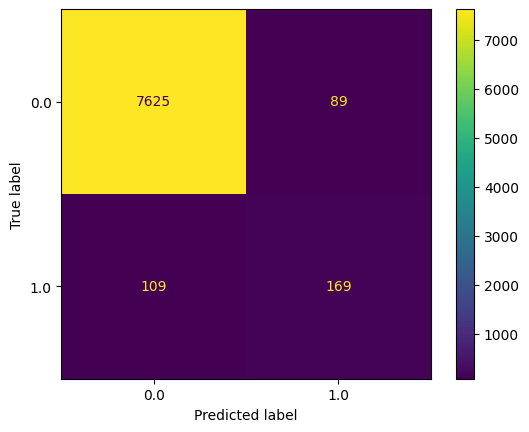

In [91]:
cm=confusion_matrix(ytrain,ypredicted)
cmplot=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
cmplot.plot()

model with oversampled data

In [92]:
model=DecisionTreeClassifier(max_depth=15)
model.fit(xtrain_sampled,ytrain_sampled)

DecisionTreeClassifier(max_depth=15)

In [93]:
model.score(xtrain_sampled,ytrain_sampled)

0.9994166450609282

In [94]:
ypredicted=cross_val_predict(model,xtrain_sampled,ytrain_sampled,cv=3)

classification report

In [95]:
print(classification_report(ytrain_sampled,ypredicted))

              precision    recall  f1-score   support

         0.0       0.96      0.97      0.97      7714
         1.0       0.97      0.96      0.97      7714

    accuracy                           0.97     15428
   macro avg       0.97      0.97      0.97     15428
weighted avg       0.97      0.97      0.97     15428



confusion matrix

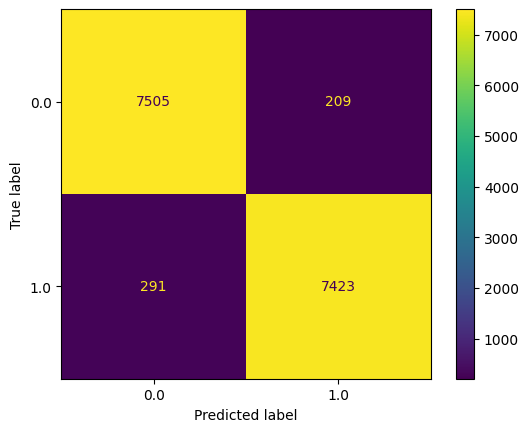

In [96]:
cm=confusion_matrix(ytrain_sampled,ypredicted)
cmplot=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
cmplot.plot()

MODEL WITH OVERSAMPLED DATA HAS BETTER PRECISION AND RECALL SO IITS THE BEST MODEL

cross validation

deeper look at evaluation metrics

precision recalll curve

In [97]:
yscores=cross_val_predict(model,xtrain_sampled,ytrain_sampled,cv=3,method="predict_proba")

In [98]:
precision,recall,thresh=precision_recall_curve(ytrain_sampled,yscores[:,1])

In [99]:
thresh.shape

(5,)

In [100]:
precision

array([0.5       , 0.9446001 , 0.9728489 , 0.97335958, 0.97348733,
       1.        ])

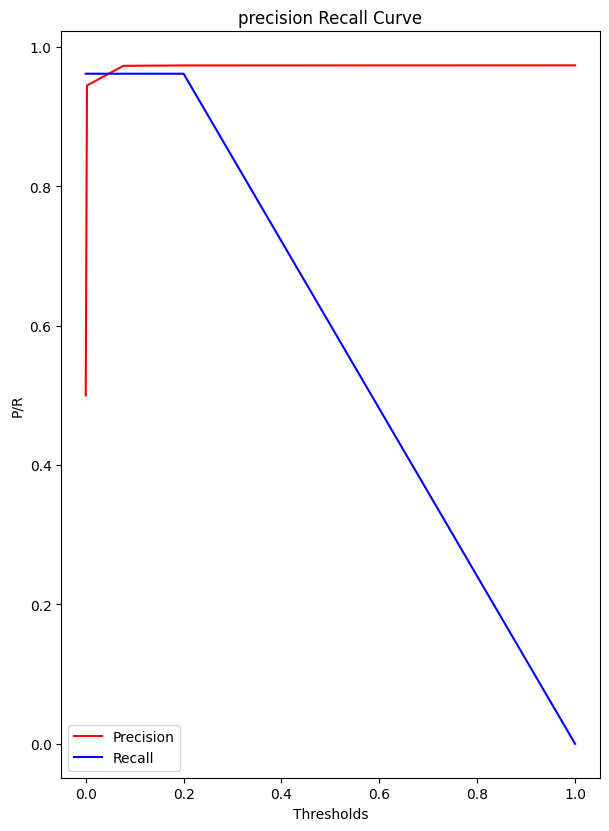

In [101]:
plt.figure(figsize=(6,8))
plt.plot(thresh,precision[:-1],'r',label='Precision')
plt.plot(thresh,recall[1:],'b',label='Recall')
plt.legend()
plt.tight_layout()
plt.xlabel("Thresholds")
plt.ylabel("P/R")
plt.title("precision Recall Curve")
plt.show()

increasing threshold always increases precision 


Recall mostly decreases with increasing thresholds

ROC curve

In [102]:
fpr, tpr, thresholds = roc_curve(ytrain_sampled, yscores[:,1])

In [103]:
thresholds.shape

(6,)

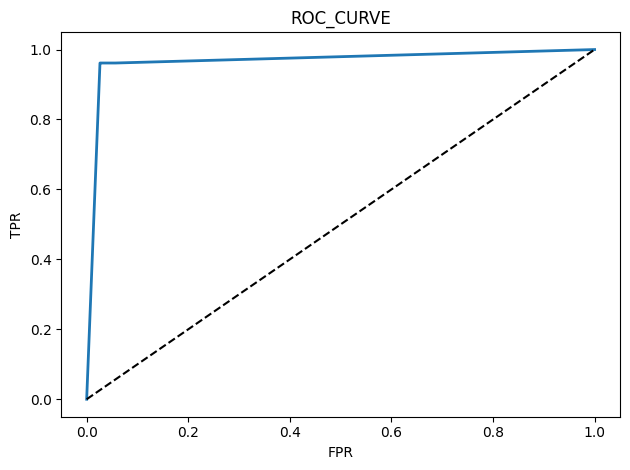

In [104]:
plt.plot(fpr, tpr, linewidth=2, label="label")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC_CURVE")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.tight_layout()
plt.show()

In [105]:
from sklearn.metrics import roc_auc_score

In [106]:
score=roc_auc_score(ytrain_sampled,yscores[:,1])

In [107]:
score

0.9670747451223071

Final Evaluation on our test data

In [108]:
xtest_transformed=full_pipe.fit_transform(xtest)

In [109]:
xtest_transformed.shape

(1999, 8)

In [110]:
ypredicted=model.predict(xtest_transformed)
print(classification_report(ypredicted,ytest))

              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98      1882
         1.0       0.77      0.46      0.58       117

    accuracy                           0.96      1999
   macro avg       0.87      0.73      0.78      1999
weighted avg       0.96      0.96      0.96      1999



ACCURACY ON TEST DATA IS ABOVE AVERAGE

NOT SO GOOD BUT RECALL IS FAIR CONSIDERIG SUPPORT OF 117

prediction on single sample input data

In [111]:
x_input=pd.DataFrame(
    np.zeros((1,6)),
    columns=xtrain.columns
)


In [112]:
xtrain

Type  AirTemp  ProcessTemp  RotationSpeed  Torque  ToolWear
5162    L    304.2        313.3         1464.0    45.9      48.0
103     M    298.8        308.8         1441.0    40.5      63.0
9408    H    297.9        308.4         1637.0    34.5     191.0
5671    H    302.2        311.6         1534.0    37.2      41.0
7480    M    300.2        311.4         1570.0    35.3     138.0
...   ...      ...          ...            ...     ...       ...
9541    M    299.5        310.8         1754.0    31.3     114.0
2492    H    299.0        308.8         1382.0    58.5     199.0
8013    M    300.9        312.0         1402.0    50.7     185.0
7562    M    300.3        311.1         1350.0    58.7     130.0
9228    M    298.1        309.1         1572.0    37.5     126.0

[7992 rows x 6 columns]

In [113]:
inp=["M",298,308,1750,30,120]

In [114]:
for xx,col in enumerate(x_input.columns):
    x_input[col]=inp[xx]

In [115]:
x_input_transformed=full_pipe.transform(x_input)

In [116]:
full_pipe.transform(x_input)

array([[-0.9975121 , -1.31906392,  1.16001214, -1.03684055,  0.21318443,
         0.        ,  0.        ,  1.        ]])

In [117]:
x_input_transformed.shape

(1, 8)

prediction from our model

In [118]:
model.predict(x_input_transformed)

array([0.])

prediction from model with pipeline

In [119]:
predict=model_pipe.predict(x_input)
predict

array([0.])

SAVING OUR MODELS

with pipeline

In [121]:
import pickle

In [122]:
with open("pipeline_model.pkl",'wb') as mp:
    pickle.dump(model_pipe,mp)

In [124]:
with open("Decision_tree_model.pkl",'wb') as mp:
    pickle.dump(model,mp)